* [Chapter 0 - Libraries and Imports](#chapter0)
* [Chapter 1 - Basic Time-to-Retraction Statistics](#chapter1)
* [Chapter 2 - Temporal trends](#chapter2)
* [Chapter 3 - Reasons for Retraction](#chapter3)
* [Chapter 4 - Geographical Differences](#chapter4)


<div class="alert alert-block alert-info" style = "background:#d0de6f; color:#000000; border:0;">

# Chapter 0 - Libraries and Imports <a class="anchor" id="chapter0"></a>

In [6]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import mannwhitneyu

In [7]:
retractions_import = pd.read_excel('./retractions_data/rw_wos_scimago_by_dois.xlsx')

In [8]:
retractions = retractions_import.copy()

In [9]:
retractions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20260 entries, 0 to 20259
Data columns (total 54 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Record ID                              20260 non-null  int64         
 1   Title                                  20260 non-null  object        
 2   Subject                                20260 non-null  object        
 3   Institution                            20259 non-null  object        
 4   Journal                                20260 non-null  object        
 5   Publisher                              20260 non-null  object        
 6   Country                                20260 non-null  object        
 7   Author                                 20260 non-null  object        
 8   URLS                                   7933 non-null   object        
 9   ArticleType                            20260 non-null  object

In [10]:
retractions['Subject'].value_counts()

Subject
(BLS) Biology - Cancer;(BLS) Biology - Cellular;(BLS) Genetics;                                                                        1180
(B/T) Computer Science;(B/T) Technology;                                                                                                317
(BLS) Biochemistry;(BLS) Biology - Cellular;                                                                                            308
(BLS) Biology - Cancer;(BLS) Biology - Cellular;(BLS) Biology - Molecular;(BLS) Genetics;                                               250
(PHY) Chemistry;                                                                                                                        213
                                                                                                                                       ... 
(PHY) Chemistry;(PHY) Crystallography/Spectroscopy;(SOC) Forensics;                                                                       1
(BLS) Bioche

<div class="alert alert-block alert-info" style = "background:#d0de6f; color:#000000; border:0;">

# Chapter 1 - Basic Retraction Statistics <a class="anchor" id="chapter1"></a>

In [11]:
# Create variable with time-to-retraction
retractions['time_to_retraction'] = ((retractions['RetractionDate']-retractions['OriginalPaperDate']) / pd.Timedelta(days=30.4375))

In [12]:
# Import excel with the classification of areas (biomed or not)
classif_areas = pd.read_excel('./research_areas_wos_classified.xlsx')
classif_areas

,Área científica,Classificação Isabel
0,GEOCHEMISTRY \& GEOPHYSICS,0
1,ONCOLOGY,1
2,BUSINESS \& ECONOMICS,0
3,PHYSICAL GEOGRAPHY,0
4,GEOLOGY,0
...,...,...
113,"DENTISTRY, ORAL SURGERY \& MEDICINE",1
114,WOMEN'S STUDIES,0
115,SPECTROSCOPY,1
116,MARINE \& FRESHWATER BIOLOGY,0


In [13]:
def create_biomed_variable(df, id):
    areas = df[[id,'research_areas']]
    areas.loc[:, 'research_areas'] = df['research_areas'].str.split(';')
    areas = areas.explode('research_areas')
    areas = areas[areas['research_areas'].str.strip() != ""]
    areas['research_areas'] = areas['research_areas'].str.strip()
    
    areas = areas.merge(classif_areas, how= 'left', left_on = 'research_areas', right_on = 'Área científica')
    areas['Biomedicine'] = np.where(areas['Classificação Isabel'] >= 1, 1, 0)

    df = df.merge(areas.groupby(id)['Biomedicine'].sum(), how='left', on = id)
    df['Biomedicine'] = np.where(df['Biomedicine']>=1, 1, 0)

    return df

In [14]:
# control_set = create_biomed_variable(control_set, 'doi')

In [15]:
retractions = create_biomed_variable(retractions, 'Record ID')

In [16]:
retractions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20260 entries, 0 to 20259
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Record ID                              20260 non-null  int64         
 1   Title                                  20260 non-null  object        
 2   Subject                                20260 non-null  object        
 3   Institution                            20259 non-null  object        
 4   Journal                                20260 non-null  object        
 5   Publisher                              20260 non-null  object        
 6   Country                                20260 non-null  object        
 7   Author                                 20260 non-null  object        
 8   URLS                                   7933 non-null   object        
 9   ArticleType                            20260 non-null  object

In [17]:
# Obtain corresponding author of article (first author in list)
retractions['corresponding_author'] = retractions['Author'].str.split(';').str[0]

In [18]:
# Create a new variable with the number of retractions the corresponding author has had 
for index, row in retractions.iterrows():
    retractions.loc[index, 'nr_of_offenses'] = retractions['Author'].str.contains(row['corresponding_author']).sum()

C:\Users\isabe\AppData\Local\Temp\ipykernel_11820\2398385438.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  retractions.loc[index, 'nr_of_offenses'] = retractions['Author'].str.contains(row['corresponding_author']).sum()


In [19]:
# Map the number of offenses into three categories
def map_to_category(nr_of_offenses):
    if nr_of_offenses == 1:
        return "1"
    elif 2 <= nr_of_offenses <= 10:
        return "2-10"
    else:
        return ">10"

retractions['groups_authors'] = retractions['nr_of_offenses'].apply(map_to_category)

In [20]:
# Alternative dataset where only the first time the author had a retraction is counted
retractions_only_first_time = retractions.sort_values(by='RetractionDate', inplace = False)
retractions_only_first_time = retractions_only_first_time.groupby('corresponding_author').first().reset_index()
retractions_only_first_time.head()

,corresponding_author,Record ID,Title,Subject,Institution,Journal,Publisher,Country,Author,URLS,...,wos_categories,total_times_cited_count,authors_affiliations,corresponding_author_affiliation,Issn,SJR Best Quartile,time_to_retraction,Biomedicine,nr_of_offenses,groups_authors
0,A A Adeniji,4320,Effects of replacing groundnut cake with rumen...,(B/T) Business - Economics;(BLS) Agriculture;(...,"Department of Animal Science, Faculty of Agric...",Lipids in Health and Disease,BioMed Central (BMC),Nigeria,A A Adeniji;S Rumak;R A Oluwafemi,None,...,BIOCHEMISTRY & MOLECULAR BIOLOGY; NUTRITION & ...,3,UNIV ABUJA,UNIV ABUJA,None,None,5.289528,0,1.0,1
1,A A Akhpashev,41086,Knee Joint Gait Function in Patients with ACL ...,(HSC) Medicine - Orthopedics;(HSC) Medicine - ...,"Peoplesâ€™ Friendship University of Russia, Ru...",Traumatology and Orthopedics of Russia (Ð¢Ñ€Ð°...,Eco-Vector,Russia,A A Akhpashev;N V Zagorodniy;A S Kanaev;S N Ka...,None,...,ORTHOPEDICS,9,None,NOTREPORTED,None,None,72.607803,1,1.0,1
2,A A Akom,21947,Breaking the Chains of Food Apartheid: Using Y...,(ENV) Food Science;(SOC) Sociology;,"San Francisco State University, San Francisco,...",Race And Social Problems,Springer,United States,A A Akom;Aekta Shah;Aaron Nakai,None,...,"ETHNIC STUDIES; SOCIAL SCIENCES, INTERDISCIPLI...",1,CALIFORNIA STATE UNIVERSITY SYSTEM; SAN FRANCI...,STANFORD UNIV,18671748,Q1,0.000000,0,1.0,1
3,A A Cherechukin,18548,Influence of three-dimensional transition elem...,(PHY) Chemistry;(PHY) Physics;,"Institute of Fluid Science, Tohoku University,...",Journal of Applied Physics,AIP Publishing,Japan,A A Cherechukin;Toshiyuki Takagi;H Miki;Minoru...,None,...,"PHYSICS, APPLIED",14,TOHOKU UNIVERSITY; AKITA PREFECTURAL UNIVERSIT...,TOHOKU UNIV,00218979,Q2,12.418891,0,1.0,1
4,A A Gadalla,26261,Synthesis and characterization of Mn-doped CdS...,(PHY) Engineering - Chemical;(PHY) Nanotechnol...,"Physics Department, Faculty of Science, Assiut...",Journal of Materials Science: Materials in Ele...,Springer,Egypt;India,A A Gadalla;A N Aboelkhir;M G Mahesha;Ashok Rao,None,...,"ENGINEERING, ELECTRICAL & ELECTRONIC; MATERIAL...",3,EGYPTIAN KNOWLEDGE BANK (EKB); ASSIUT UNIVERSI...,ASSIUT UNIV;MANIPAL INST TECHNOL,09574522,Q2,11.137577,0,1.0,1


In [21]:
retractions_only_first_time.shape

(15866, 59)

## Original TTR (without alterations)

In [22]:
# Save the TTR into separate variables
biomedicine_retractions = retractions[retractions['Biomedicine'] == 1]
non_biomedicine_retractions = retractions[retractions['Biomedicine'] == 0]

In [23]:
ttr_total_stats = retractions['time_to_retraction'].describe().rename('ttr_total_stats')
ttr_biomed_stats = biomedicine_retractions['time_to_retraction'].describe().rename('ttr_biomed_stats')
ttr_non_biomed_stats = non_biomedicine_retractions['time_to_retraction'].describe().rename('ttr_non_biomed_stats')
ttr_stats = pd.concat([ttr_total_stats, ttr_biomed_stats, ttr_non_biomed_stats], axis = 1)
ttr_stats.round(1)

,ttr_total_stats,ttr_biomed_stats,ttr_non_biomed_stats
count,20260.0,5374.0,14886.0
mean,38.8,43.5,37.2
std,45.6,44.3,46.0
min,0.0,0.0,0.0
25%,10.2,12.9,9.7
50%,23.0,31.2,20.7
75%,50.5,57.3,47.7
max,641.0,388.9,641.0


Wilcoxon–Mann–Whitney test

In [24]:
# Wilcoxon-Mann-Whitney test to see if difference in distribution of biomed and non biomed are different
statistic, p_value = mannwhitneyu(biomedicine_retractions['time_to_retraction'], non_biomedicine_retractions['time_to_retraction'])

print("Mann-Whitney U test statistic:", statistic)
print("P-value:", p_value)

Mann-Whitney U test statistic: 45478671.0
P-value: 2.7975864487279744e-50


Given that
- H0: biomedicine_dist = non_biomedicine_dist
- H1: biomedicine_dist != non_biomedicine_dist

There is statistical evidence that the time-to-retraction of biomed articles has a different distribution than the non-biomed ones.

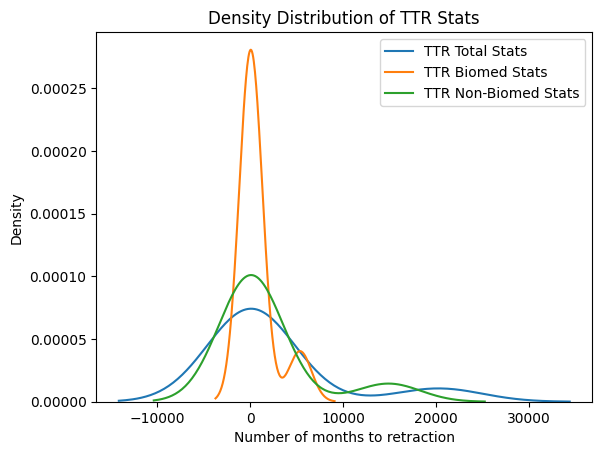

In [25]:
# Plotting
sns.kdeplot(ttr_total_stats, label='TTR Total Stats')
sns.kdeplot(ttr_biomed_stats, label='TTR Biomed Stats')
sns.kdeplot(ttr_non_biomed_stats, label='TTR Non-Biomed Stats')

# Customize plot (labels, title, etc.)
plt.xlabel('Number of months to retraction')  # Customize X-axis label
plt.ylabel('Density')  # Customize Y-axis label
plt.title('Density Distribution of TTR Stats')  # Add title
plt.legend()  # Show legend

# Show plot
plt.show()

c:\Users\isabe\Desktop\Tese\tese\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


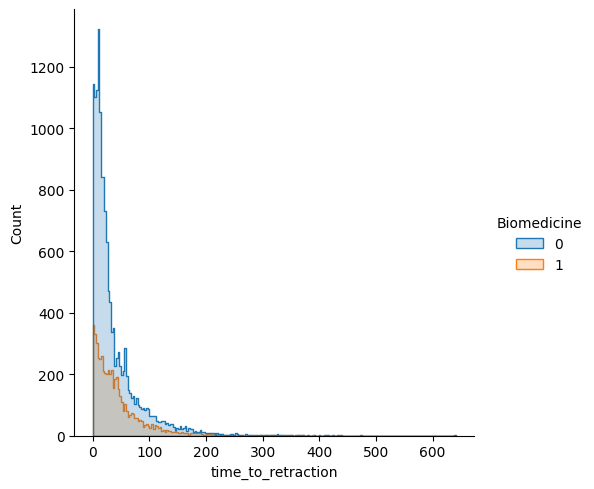

In [26]:
sns.displot(retractions, x = 'time_to_retraction', hue = 'Biomedicine', element='step')

## TTR of first article to be retracted of each author

In [27]:
# Save the TTR into separate variables
first_biomedicine_retractions = retractions_only_first_time[retractions_only_first_time['Biomedicine'] == 1]['time_to_retraction']
first_non_biomedicine_retractions = retractions_only_first_time[retractions_only_first_time['Biomedicine'] == 0]['time_to_retraction']

In [28]:
first_ttr_total_stats = retractions_only_first_time['time_to_retraction'].describe().rename('ttr_total_stats')
first_ttr_biomed_stats = first_biomedicine_retractions.describe().rename('ttr_biomed_stats')
first_ttr_non_biomed_stats = first_non_biomedicine_retractions.describe().rename('ttr_non_biomed_stats')
first_ttr_stats = pd.concat([ttr_total_stats, ttr_biomed_stats, ttr_non_biomed_stats], axis = 1)
first_ttr_stats.round(1)

,ttr_total_stats,ttr_biomed_stats,ttr_non_biomed_stats
count,20260.0,5374.0,14886.0
mean,38.8,43.5,37.2
std,45.6,44.3,46.0
min,0.0,0.0,0.0
25%,10.2,12.9,9.7
50%,23.0,31.2,20.7
75%,50.5,57.3,47.7
max,641.0,388.9,641.0


In [29]:
# Wilcoxon-Mann-Whitney test to see if difference in distribution of biomed and non biomed are different
statistic, p_value = mannwhitneyu(first_biomedicine_retractions, first_non_biomedicine_retractions)

print("Mann-Whitney U test statistic:", statistic)
print("P-value:", p_value)

Mann-Whitney U test statistic: 28289797.0
P-value: 9.013947440886752e-47


There is statistical evidence that the time-to-retraction of biomed articles has a different distribution than the non-biomed ones.

c:\Users\isabe\Desktop\Tese\tese\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


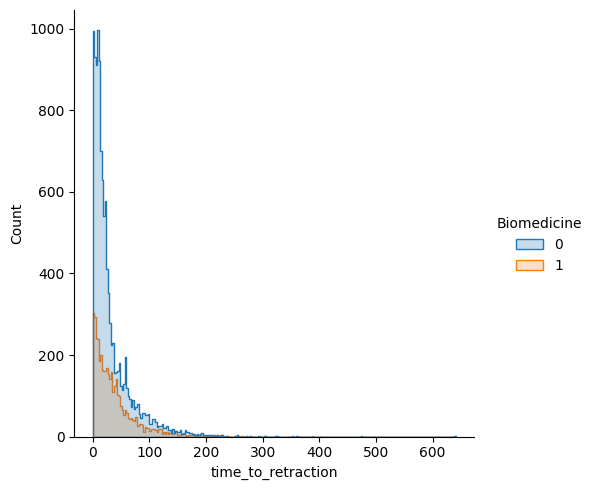

In [30]:
sns.displot(retractions_only_first_time, x = 'time_to_retraction', hue = 'Biomedicine', element='step')

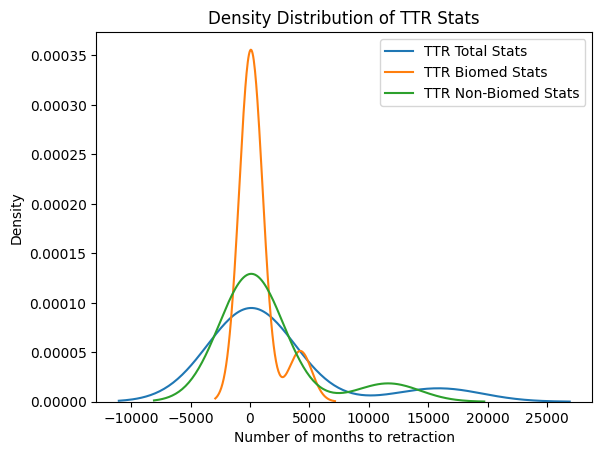

In [31]:
# Plotting
sns.kdeplot(first_ttr_total_stats, label='TTR Total Stats')
sns.kdeplot(first_ttr_biomed_stats, label='TTR Biomed Stats')
sns.kdeplot(first_ttr_non_biomed_stats, label='TTR Non-Biomed Stats')

# Customize plot (labels, title, etc.)
plt.xlabel('Number of months to retraction')  # Customize X-axis label
plt.ylabel('Density')  # Customize Y-axis label
plt.title('Density Distribution of TTR Stats')  # Add title
plt.legend()  # Show legend

# Show plot
plt.show()

## TTR by category of author

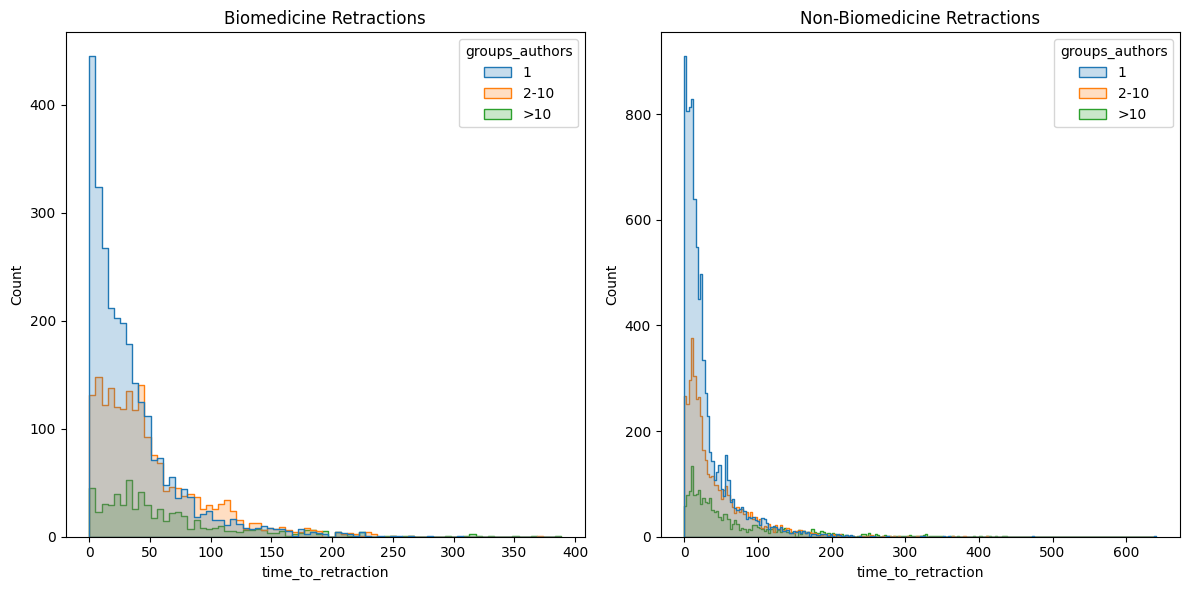

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define order of categories
category_order = ['1', '2-10', '>10']

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for biomedicine retractions
sns.histplot(biomedicine_retractions, x='time_to_retraction', hue='groups_authors', element='step', ax=ax[0], hue_order=category_order)
ax[0].set_title('Biomedicine Retractions')

# Plot for non-biomedicine retractions
sns.histplot(non_biomedicine_retractions, x='time_to_retraction', hue='groups_authors', element='step', ax=ax[1], hue_order=category_order)
ax[1].set_title('Non-Biomedicine Retractions')

# Set legend labels
handles, labels = ax[0].get_legend_handles_labels()
#ax[1].legend(handles, labels, title='Groups Authors')

plt.tight_layout()
plt.show()


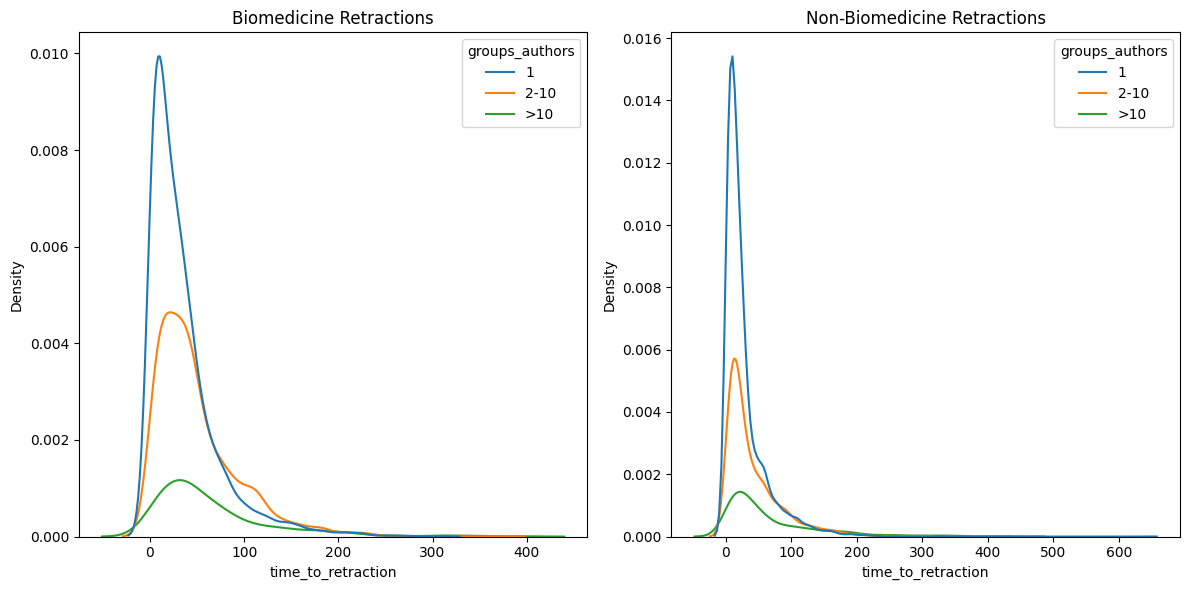

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for biomedicine retractions
sns.kdeplot(data=biomedicine_retractions, x='time_to_retraction', hue='groups_authors', ax=ax[0], hue_order=category_order)
ax[0].set_title('Biomedicine Retractions')

# Plot for non-biomedicine retractions
sns.kdeplot(data=non_biomedicine_retractions, x='time_to_retraction', hue='groups_authors', ax=ax[1], hue_order=category_order)
ax[1].set_title('Non-Biomedicine Retractions')

plt.tight_layout()
plt.show()

In [232]:
# Total retractions stats
retractions.groupby('groups_authors')['time_to_retraction'].describe()

,count,mean,std,min,25%,50%,75%,max
groups_authors,,,,,,,,
1,11227.0,29.850766,35.576710,0.0,7.950719,17.938398,37.585216,641.018480
2-10,6490.0,43.909251,44.015133,0.0,13.075975,29.486653,59.786448,412.747433
>10,2543.0,65.611084,70.091979,0.0,18.595483,40.673511,88.558522,437.453799


In [233]:
# Biomed retractions stats
biomedicine_retractions.groupby('groups_authors')['time_to_retraction'].describe()

,count,mean,std,min,25%,50%,75%,max
groups_authors,,,,,,,,
1,2802.0,34.693764,37.654022,0.0,8.969199,23.917864,45.757700,305.347023
2-10,1953.0,49.508333,43.510483,0.0,17.938398,38.176591,67.712526,369.577002
>10,619.0,64.381512,61.522334,0.0,23.983573,45.043121,80.903491,388.862423


In [234]:
# Non-Biomed retractions stats
non_biomedicine_retractions.groupby('groups_authors')['time_to_retraction'].describe()

,count,mean,std,min,25%,50%,75%,max
groups_authors,,,,,,,,
1,8425.0,28.240075,34.711311,0.0,7.753593,16.525667,33.806982,641.018480
2-10,4537.0,41.499067,44.016575,0.0,11.696099,25.034908,57.494867,412.747433
>10,1924.0,66.006668,72.644819,0.0,16.952772,37.963039,91.778234,437.453799


<div class="alert alert-block alert-info" style = "background:#d0de6f; color:#000000; border:0;">

# Chapter 2 - Temporal trends <a class="anchor" id="chapter2"></a>

In [235]:
retractions.columns

Index(['Record ID', 'Title', 'Subject', 'Institution', 'Journal', 'Publisher',
       'Country', 'Author', 'URLS', 'ArticleType', 'RetractionDate',
       'RetractionDOI', 'RetractionPubMedID', 'OriginalPaperDate',
       'OriginalPaperDOI', 'OriginalPaperPubMedID', 'RetractionNature',
       'Reason', 'Paywalled', 'Notes', 'authors', 'author_fullnames',
       'cited_references', 'abstract', 'author_keywords', 'doi',
       'document_type', 'funding_agency_and_grant_number', 'esi_highly_cited',
       'esi_hot_paper', 'keywords_plus', 'language', 'early_access_date',
       'cited_reference_count', 'open_access_indicator', 'orcid',
       'publication_date', 'page_count', 'pubmed_id', 'publication_type',
       'publisher', 'year_published', 'researcher_id_nr', 'research_areas',
       'issn', 'publication_name', 'wos_core_collection_times_cited_count',
       'document_title', 'wos_categories', 'total_times_cited_count',
       'authors_affiliations', 'corresponding_author_affiliatio

In [236]:
retractions_grouped = retractions[retractions['year_published'] != 2023].groupby(retractions['year_published'])['time_to_retraction'].mean().reset_index(name= 'Mean TTR of Retractions')

# Merge the two grouped DataFrames on the 'year_published' column
year_counts = retractions_grouped.copy()

In [237]:
ttr_of_biomed_retracted = retractions[retractions['Biomedicine'] ==1].groupby(retractions['year_published'])['time_to_retraction'].mean().reset_index(name= 'Mean TTR of Retractions in Biomedicine')
ttr_of_non_biomed_retracted = retractions[retractions['Biomedicine'] ==0].groupby(retractions['year_published'])['time_to_retraction'].mean().reset_index(name= 'Mean TTR of Retractions not in Biomedicine')

In [238]:
year_counts = pd.merge(year_counts, ttr_of_biomed_retracted, how='left', on='year_published')
year_counts = pd.merge(year_counts, ttr_of_non_biomed_retracted, how='left', on='year_published')

In [239]:
#year_counts

In [240]:
import matplotlib.pyplot as plt

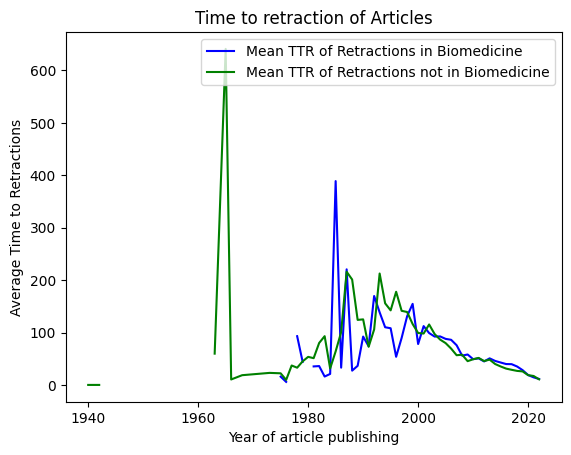

In [241]:
plt.plot(year_counts['year_published'], year_counts['Mean TTR of Retractions in Biomedicine'], label = 'Mean TTR of Retractions in Biomedicine', color="b")
plt.plot(year_counts['year_published'], year_counts['Mean TTR of Retractions not in Biomedicine'], label = 'Mean TTR of Retractions not in Biomedicine', color="g")

plt.xlabel('Year of article publishing')
plt.ylabel('Average Time to Retractions')
plt.title('Time to retraction of Articles')
plt.legend()
plt.show()

In [242]:
retractions_grouped = retractions.groupby(retractions['RetractionDate'].dt.year)['time_to_retraction'].mean().reset_index(name= 'Mean TTR of Retractions')

# Merge the two grouped DataFrames on the 'year_published' column
year_counts_retracted_date = retractions_grouped.copy()

In [243]:
ttr_of_biomed_retracted = biomedicine_retractions.groupby(retractions['RetractionDate'].dt.year)['time_to_retraction'].mean().reset_index(name= 'Mean TTR of Retractions in Biomedicine')
ttr_of_non_biomed_retracted = non_biomedicine_retractions.groupby(retractions['RetractionDate'].dt.year)['time_to_retraction'].mean().reset_index(name= 'Mean TTR of Retractions not in Biomedicine')

In [244]:
year_counts_retracted_date = pd.merge(year_counts_retracted_date, ttr_of_biomed_retracted, how='left', on='RetractionDate')
year_counts_retracted_date = pd.merge(year_counts_retracted_date, ttr_of_non_biomed_retracted, how='left', on='RetractionDate')

In [245]:
#year_counts_retracted_date

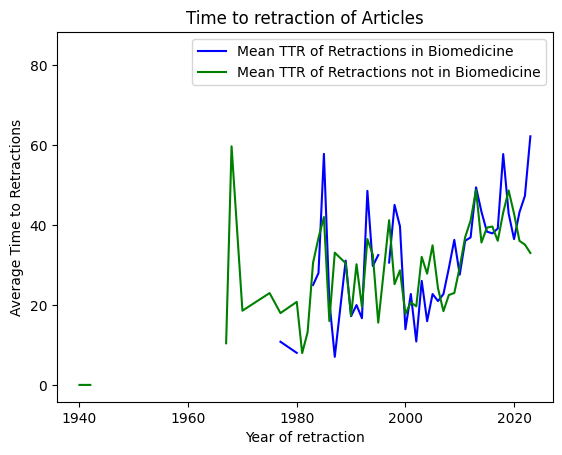

In [246]:
plt.plot(year_counts_retracted_date['RetractionDate'], year_counts_retracted_date['Mean TTR of Retractions in Biomedicine'], label = 'Mean TTR of Retractions in Biomedicine', color="b")
plt.plot(year_counts_retracted_date['RetractionDate'], year_counts_retracted_date['Mean TTR of Retractions not in Biomedicine'], label = 'Mean TTR of Retractions not in Biomedicine', color="g")

plt.xlabel('Year of retraction')
plt.ylabel('Average Time to Retractions')
plt.title('Time to retraction of Articles')
plt.legend()
plt.show()

<div class="alert alert-block alert-info" style = "background:#d0de6f; color:#000000; border:0;">

# Chapter 3 - Reasons for Retraction <a class="anchor" id="chapter3"></a>

In [247]:
# Import excel with the classification of areas (biomed or not)
classif_misconduct = pd.read_excel('./misconduct_classified.xlsx')
classif_misconduct

,Reason,Misconduct
0,Concerns/Issues About Authorship,0
1,Misconduct by Author,1
2,Error in Results and/or Conclusions,0
3,Investigation by Journal/Publisher,1
4,Investigation by Company/Institution,1
...,...,...
102,Nonpayment of Fees/Refusal to Pay,0
103,No Further Action,0
104,Error in Image,0
105,Fake Peer Review,1


In [254]:
def create_misconduct_variable(df, id):
    motives = retractions[['Record ID','Reason', 'Biomedicine', "time_to_retraction"]]
    motives.loc[:, 'Reason'] = motives['Reason'].str.split(';')
    motives = motives.explode('Reason')
    motives.loc[:, 'Reason'] = motives['Reason'].str.replace('+', '')
    motives = motives[motives['Reason'].str.strip() != ""]
    
    motives = motives.merge(classif_misconduct, how= 'left', left_on = 'Reason', right_on = 'Reason')
    motives['Misconduct'] = np.where(motives['Misconduct'] >= 1, 1, 0)

    df = df.merge(motives.groupby(id)['Misconduct'].sum(), how='left', on = id)
    df['Misconduct'] = np.where(df['Misconduct']>=1, 1, 0)
    
    
    return df

In [255]:
# control_set = create_biomed_variable(control_set, 'doi')

In [256]:
retractions = create_misconduct_variable(retractions, 'Record ID')

In [281]:
motives = retractions[['Record ID','Reason', 'Biomedicine', "time_to_retraction", "Misconduct", 'RetractionDate']]
motives.loc[:, 'Reason'] = motives['Reason'].str.split(';')
motives = motives.explode('Reason')
motives.loc[:, 'Reason'] = motives['Reason'].str.replace('+', '')
motives = motives[motives['Reason'].str.strip() != ""]
motives


,Record ID,Reason,Biomedicine,time_to_retraction,Misconduct,RetractionDate
0,5729,Concerns/Issues About Authorship,0,132.796715,1,2016-09-01
0,5729,Concerns/Issues About Data,0,132.796715,1,2016-09-01
0,5729,Misconduct by Author,0,132.796715,1,2016-09-01
1,5728,Concerns/Issues About Authorship,0,133.026694,1,2016-09-01
1,5728,Concerns/Issues About Data,0,133.026694,1,2016-09-01
...,...,...,...,...,...,...
20258,30815,Concerns/Issues About Authorship,0,0.000000,0,2019-02-01
20259,44706,Concerns/Issues About Image,1,26.119097,1,2017-05-26
20259,44706,Copyright Claims,1,26.119097,1,2017-05-26
20259,44706,Lack of Approval from Author,1,26.119097,1,2017-05-26


In [282]:
top10_reasons_biomed = motives[motives['Biomedicine']==1].groupby('Reason').size().reset_index(name = "Biomed")
top10_reasons_non_biomed = motives[motives['Biomedicine']==0].groupby('Reason').size().reset_index(name = "Non Biomed")

In [283]:
top10_reasons = pd.concat([top10_reasons_biomed, top10_reasons_non_biomed], axis=1)
top10_reasons

,Reason,Biomed,Reason,Non Biomed
0,Author Unresponsive,368.0,Author Unresponsive,540
1,Bias Issues or Lack of Balance,10.0,Bias Issues or Lack of Balance,33
2,Breach of Policy by Author,58.0,Breach of Policy by Author,237
3,Breach of Policy by Third Party,2.0,Cites Retracted Work,66
4,Cites Retracted Work,27.0,Civil Proceedings,13
...,...,...,...,...
99,Withdrawal,100.0,Updated to Retraction,3
100,Withdrawn to Publish in Different Journal,6.0,Upgrade/Update of Prior Notice,472
101,NaN,NaN,Withdrawal,474
102,NaN,NaN,Withdrawn (out of date),135


In [284]:
top10_ttr_reasons_biomed = motives[motives['Biomedicine']==1].groupby('Reason')['time_to_retraction'].mean().reset_index(name = "TTR Biomed")
top10_ttr_reasons_non_biomed = motives[motives['Biomedicine']==0].groupby('Reason')['time_to_retraction'].mean().reset_index(name = "TTR Non Biomed")

In [285]:
top10_reasons_ttr = pd.concat([top10_ttr_reasons_biomed, top10_ttr_reasons_non_biomed], axis=1)
top10_reasons_ttr[:10]

,Reason,TTR Biomed,Reason,TTR Non Biomed
0,Author Unresponsive,49.208464,Author Unresponsive,39.172987
1,Bias Issues or Lack of Balance,55.697741,Bias Issues or Lack of Balance,54.819737
2,Breach of Policy by Author,33.944629,Breach of Policy by Author,26.114660
3,Breach of Policy by Third Party,10.529774,Cites Retracted Work,76.308879
4,Cites Retracted Work,59.242224,Civil Proceedings,65.761491
5,Civil Proceedings,112.936345,Complaints about Author,58.015667
6,Complaints about Author,14.308008,Complaints about Company/Institution,31.507187
7,Complaints about Third Party,28.501027,Complaints about Third Party,20.057495
8,Concerns/Issues About Authorship,30.139155,Concerns/Issues About Authorship,25.601554
9,Concerns/Issues About Data,48.728761,Concerns/Issues About Data,39.304574


In [286]:
motives.groupby(['Biomedicine', 'Misconduct']).size()

Biomedicine  Misconduct
0            0              9674
             1             35951
1            0              4653
             1             12123
dtype: int64

In [287]:
motives['year'] = motives['RetractionDate'].dt.year

Number of retraction comparing misconduct with other reasons

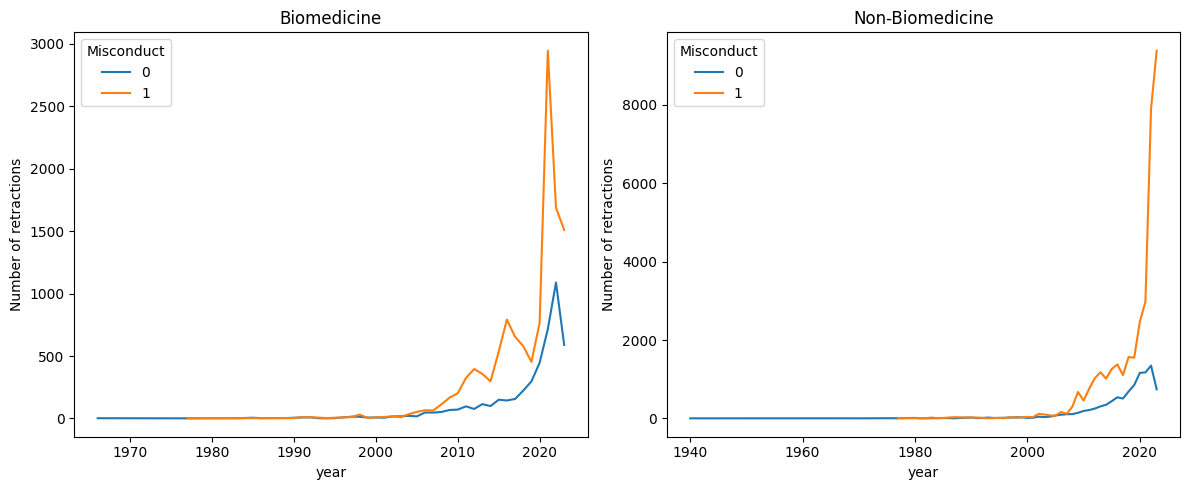

In [298]:
gby = pd.DataFrame(motives.groupby(['Misconduct', 'year', 'Biomedicine']).size().reset_index(name="Number of retractions"))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting first line plot
sns.lineplot(data=gby[gby['Biomedicine']==1], x="year", y="Number of retractions", hue="Misconduct", ax=axes[0])
axes[0].set_title('Biomedicine')

# Plotting second line plot
sns.lineplot(data=gby[gby['Biomedicine']==0], x="year", y="Number of retractions", hue="Misconduct", ax=axes[1])
axes[1].set_title('Non-Biomedicine')

plt.tight_layout()
plt.show()

Time-to-retraction

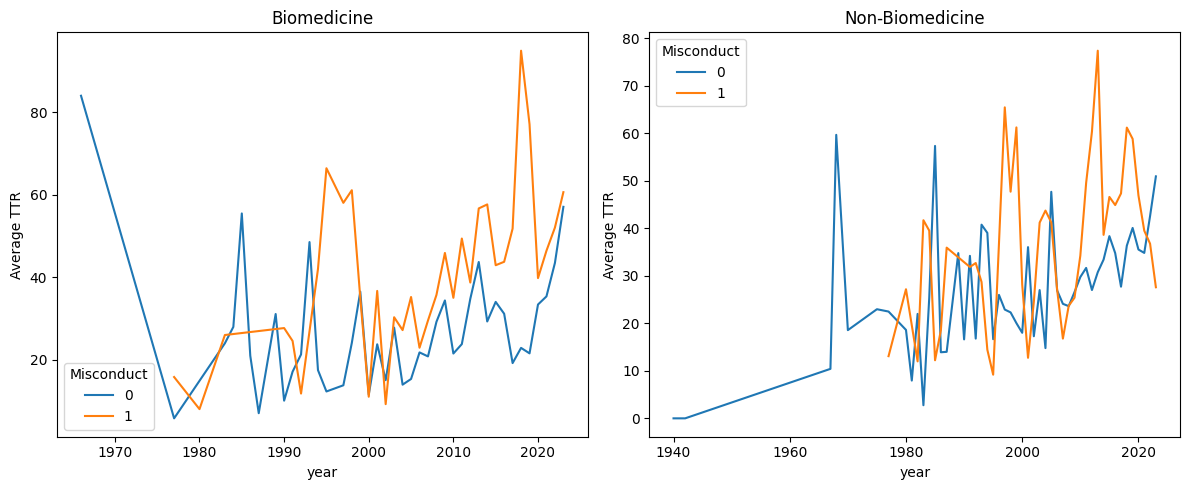

In [299]:
gby = pd.DataFrame(motives.groupby(['Misconduct', 'year', 'Biomedicine'])['time_to_retraction'].mean().reset_index(name = "Average TTR"))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting first line plot
sns.lineplot(data=gby[gby['Biomedicine']==1], x="year", y="Average TTR", hue="Misconduct", ax=axes[0])
axes[0].set_title('Biomedicine')

# Plotting second line plot
sns.lineplot(data=gby[gby['Biomedicine']==0], x="year", y="Average TTR", hue="Misconduct", ax=axes[1])
axes[1].set_title('Non-Biomedicine')

plt.tight_layout()
plt.show()

In [279]:
#groupby_reasons = pd.DataFrame(motives.groupby(['Reason', 'Biomedicine']).size().reset_index(name = "Number of retractions"))

Atenção: o gráfico seguinte não está correto (ainda)

In [189]:
import plotly.graph_objects as go

# Group by motive and calculate the sum of biomed and non-biomed observations
grouped_data_biomed = motives[motives['Biomedicine'] == 1].groupby('Reason').sum()
grouped_data_non_biomed = motives[motives['Biomedicine'] == 0].groupby('Reason').sum()

# Filter out rows where both biomed and non-biomed observations are 0
grouped_data_biomed = grouped_data_biomed[grouped_data_biomed['Biomedicine'] == 1]
grouped_data_non_biomed = grouped_data_non_biomed[grouped_data_non_biomed['Biomedicine'] == 0]

# Sort motives by the sum of biomed and non-biomed observations and select the top 10
top_biomed_motives = grouped_data_biomed['Biomedicine'].nlargest(10).index.tolist()
top_non_biomed_motives = grouped_data_non_biomed['Biomedicine'].nlargest(10).index.tolist()

# Filter out only the top 10 motives
grouped_data_biomed = grouped_data_biomed[grouped_data_biomed.index.isin(top_biomed_motives)]
grouped_data_non_biomed = grouped_data_non_biomed[grouped_data_non_biomed.index.isin(top_non_biomed_motives)]

# Create labels for Sankey diagram
labels = grouped_data_biomed.index.tolist() + grouped_data_non_biomed.index.tolist()

# Create sources and targets for Sankey diagram
sources = []
targets = []

for i, label in enumerate(grouped_data_biomed.index):
    sources.extend([i] * len(grouped_data_non_biomed))
    targets.extend(list(range(len(grouped_data_biomed), len(labels))))

for i, label in enumerate(grouped_data_non_biomed.index):
    sources.extend(list(range(len(grouped_data_biomed))))
    targets.extend([i + len(grouped_data_biomed)] * len(grouped_data_biomed))

# Append values for biomed and non-biomed observations
values = []
values.extend(grouped_data_biomed['Biomedicine'].tolist() * len(grouped_data_non_biomed))
values.extend(grouped_data_non_biomed['Biomedicine'].tolist() * len(grouped_data_biomed))

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ))])

fig.update_layout(title_text="Top 10 Motives Biomed vs. Non-Biomed", font_size=10)
fig.show()


<div class="alert alert-block alert-info" style = "background:#d0de6f; color:#000000; border:0;">

# Chapter 4 - Geographical Differences <a class="anchor" id="chapter4"></a>

In [300]:
country = retractions.copy()
country['Country_Count'] = retractions['Country'].str.split(';').apply(len)
country['Single_Multiple_Country'] = country['Country_Count'].apply(lambda x: 'Single Country' if x == 1 else 'Multiple Countries')
country = country[['Record ID','Country', 'Single_Multiple_Country', 'Biomedicine', 'time_to_retraction']]
country.loc[:, 'Country'] = country['Country'].str.split(';')
country = country.explode('Country')
country

,Record ID,Country,Single_Multiple_Country,Biomedicine,time_to_retraction
0,5729,Japan,Single Country,0,132.796715
1,5728,Japan,Single Country,0,133.026694
2,895,Finland,Multiple Countries,0,11.268994
2,895,Greece,Multiple Countries,0,11.268994
2,895,Italy,Multiple Countries,0,11.268994
...,...,...,...,...,...
20256,18340,Nepal,Multiple Countries,0,8.049281
20256,18340,Pakistan,Multiple Countries,0,8.049281
20257,30813,Iran,Single Country,0,6.143737
20258,30815,India,Single Country,0,0.000000


In [301]:
top10_ttr_countries_biomed = country[country['Biomedicine']==1].groupby('Country')['time_to_retraction'].mean().reset_index(name = "TTR Biomed")
top10_ttr_countries_non_biomed = country[country['Biomedicine']==0].groupby('Country')['time_to_retraction'].mean().reset_index(name = "TTR Non Biomed")

In [302]:
top10_countries_ttr = pd.concat([top10_ttr_countries_biomed, top10_ttr_countries_non_biomed], axis=1)
top10_countries_ttr[:10]

,Country,TTR Biomed,Country,TTR Non Biomed
0,Algeria,79.572895,Afghanistan,13.678303
1,Argentina,29.545791,Albania,1.544148
2,Armenia,3.581109,Algeria,23.789817
3,Aruba,14.751540,Anguilla,1.084189
4,Australia,31.407274,Argentina,50.819489
5,Austria,67.836361,Armenia,15.671458
6,Azerbaijan,45.963039,Aruba,4.763860
7,Bahrain,22.357290,Australia,41.868997
8,Bangladesh,17.057906,Austria,21.767503
9,Belgium,70.251426,Azerbaijan,18.830938


In [318]:
country_counts = country[country['Biomedicine']==1].groupby(['Country', 'Single_Multiple_Country'])['time_to_retraction'].mean().reset_index(name='TTR')

# Sort the DataFrame by TTR in descending order and take the top 15 countries
top_15_countries = country_counts.sort_values(by='TTR', ascending=False).head(20)

# Create a histogram with countries on the y-axis
fig = px.bar(top_15_countries, y='Country', x='TTR', color='Single_Multiple_Country',
             orientation='h',  # Horizontal orientation for countries on the y-axis
             title='Top 15 Countries with Highest Time to Retraction in Biomedicine',
             labels={'Single_Multiple_Country': 'Publication Category', 'Time to Retraction': 'TTR'},
             category_orders={'Single_Multiple_Country': ['Single Country', 'Multiple Countries']})

fig.update_layout(barmode='stack')  # Stacked histogram

fig.show()

In [319]:
country_counts = country[country['Biomedicine']==0].groupby(['Country', 'Single_Multiple_Country'])['time_to_retraction'].mean().reset_index(name='TTR')

# Sort the DataFrame by TTR in descending order and take the top 15 countries
top_15_countries = country_counts.sort_values(by='TTR', ascending=False).head(20)

# Create a histogram with countries on the y-axis
fig = px.bar(top_15_countries, y='Country', x='TTR', color='Single_Multiple_Country',
             orientation='h',  # Horizontal orientation for countries on the y-axis
             title='Top 15 Countries with Highest Time to Retraction Not in Biomedicine',
             labels={'Single_Multiple_Country': 'Publication Category', 'Time to Retraction': 'TTR'},
             category_orders={'Single_Multiple_Country': ['Single Country', 'Multiple Countries']})

fig.update_layout(barmode='stack')  # Stacked histogram

fig.show()

In [307]:
country_codes = pd.read_excel('../country_codes.xlsx')
country_codes

,country,alpha2_code,alpha3_code,numeric
0,Afghanistan,AF,AFG,4
1,Åland Islands,AX,ALA,248
2,Albania,AL,ALB,8
3,Algeria,DZ,DZA,12
4,American Samoa,AS,ASM,16
...,...,...,...,...
246,Yemen,YE,YEM,887
247,Zambia,ZM,ZMB,894
248,Zimbabwe,ZW,ZWE,716
249,Gaza Strip,PS,PSE,275


Biomedicine

In [317]:
countries = retractions.merge(country_codes, how='left', left_on="Country", right_on='country')

# Group by 'alpha3_code' and 'Country' and count the number of records in each group
country_counts = countries[countries['Biomedicine']==1].groupby(['alpha3_code', 'Country'])['time_to_retraction'].mean().reset_index(name='TTR')


fig = px.choropleth(country_counts, locations="alpha3_code",
                    color="TTR",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

Non-Biomedicine

In [316]:
countries = retractions.merge(country_codes, how='left', left_on="Country", right_on='country')

# Group by 'alpha3_code' and 'Country' and count the number of records in each group
country_counts = countries[countries['Biomedicine']==0].groupby(['alpha3_code', 'Country'])['time_to_retraction'].mean().reset_index(name='TTR')


fig = px.choropleth(country_counts, locations="alpha3_code",
                    color="TTR",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()
